In [1]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = (25, 10)

import netCDF4
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

from pathlib import Path

Populating the interactive namespace from numpy and matplotlib


In [2]:
from hypercc.data.box import Box
from hypercc.data.data_set import DataSet
from hypercc.units import unit
from hypercc.plotting import (
    plot_mollweide, plot_orthographic_np, plot_plate_carree, earth_plot,
    plot_signal_histogram)
from hypercc.filters import (taper_masked_area, gaussian_filter, sobel_filter)
from hypercc.calibration import (calibrate_sobel)

# Settings

In [3]:
month = 3

sigma_d = unit('100 km')
sigma_t = unit('3 year')

gamma = 1
scaling_factor = gamma * unit('1 km/year')
sobel_delta_t = unit('1 year')
sobel_delta_d = sobel_delta_t * scaling_factor
sobel_weights = [sobel_delta_t, sobel_delta_d, sobel_delta_d]

#data_folder = Path("/mnt/D_DRIVE/datamining/edges/testcases")
data_folder = Path("/media/sf_D_DRIVE/datamining/edges/testcases")
#data_folder = Path("/mnt/Knolselderij/bulk/Abrupt/testcases/")

model = 'MIROC-ESM'
variable = 'test7'

#data_folder = Path("/mnt/D_DRIVE/CMIP5/data_duplicate")
#model = 'HadGEM2-ES'
#variable = 'treeFrac'

data_set = DataSet.cmip5(
    path=data_folder,
    model=model,  # 'GFDL-ESM2M', # 'GFDL-CM3',  # 'GFDL-ESM2G',
    variable=variable,
    scenario='rcp85',
    realization='r1i1p1',
)[month-1::12]

## Load and inspect the data

Next we define a `box`. The box contains all information on the geometry of the data. It loads the lattitudes and longitudes of the grid points from the NetCDF file and computes quantities like resolution.

In [4]:
from datetime import date, timedelta

box = data_set.box

print("({:.6~P}, {:.6~P}, {:.6~P}) per pixel".format(*box.resolution))
for t in box.time[:3]:
    print(box.date(t), end=', ')
print(" ...")

dt = box.time[1:] - box.time[:-1]
print("time steps: max", dt.max(), "min", dt.min())

(1.0 year, 310.239 km, 312.736 km) per pixel
2006-03-16, 2007-03-16, 2008-03-16,  ...
time steps: max 366.0 min 365.0


The ``Box`` class has the nice feature that you can select slices from it, and the information will adapt. The data we loaded contains monthly snapshots. If we select one snapshot in twelve, we obtain yearly data for that month. The ``Box`` class stores the axis grid points internally and slices the time axis accordingly.

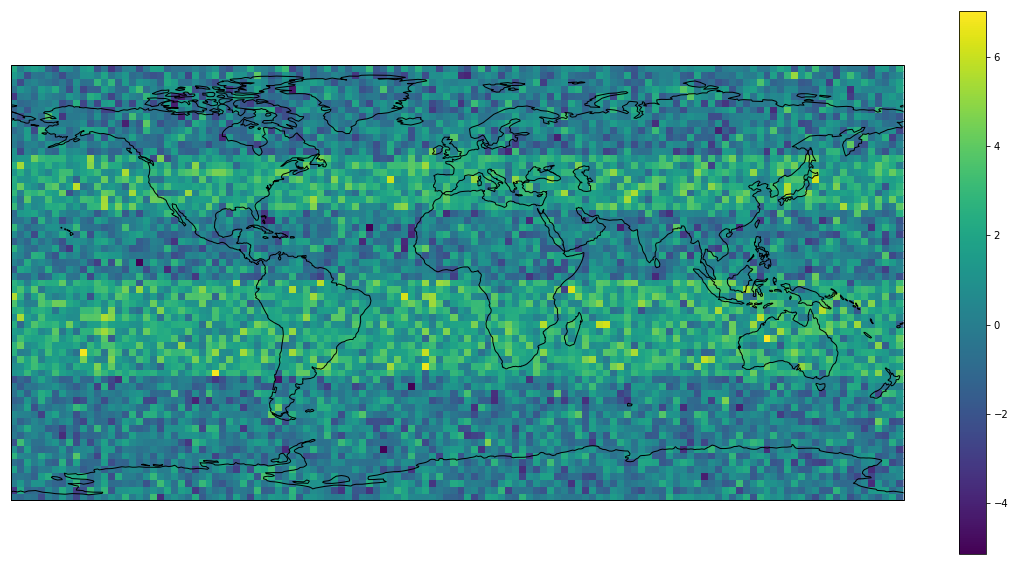

In [5]:
plot_plate_carree(box, (data_set.data[94]-data_set.data[0]).filled(0.0))

## Calibration

In [6]:
control_set = DataSet.cmip5(
    path=data_folder, model=model, variable=variable,
    scenario='piControl', realization='r1i1p1')[month-1::12]

control_data = control_set.data
control_box = control_set.box

In [7]:
taper_masked_area(control_data, [0, 5, 5], 50)

Mask is empty, not doing anything.


In [8]:
smooth_control_data = gaussian_filter(control_box, control_data, [sigma_t, sigma_d, sigma_d])

In [9]:
calibration = calibrate_sobel(control_box, smooth_control_data, sobel_delta_t, sobel_delta_d)

for k, v in calibration.items():
    print("{:10}: {}".format(k, v))
print("recommended setting for gamma: ", calibration['gamma'][3])

time      : [0.         0.01458766 0.03193764 0.05592216 0.24916454]
gamma     : [ 0.        21.148172  29.172718  34.300365   0.7719624]
distance  : [1.3866735e-06 6.8978331e-04 1.0947777e-03 1.6303663e-03 3.2276770e-01]
magnitude : [4.1423809e-05 1.5047336e-02 3.2952607e-02 5.8387175e-02 3.6892208e-01]
recommended setting for gamma:  34.300365


In [10]:
#gamma_cal = calibration['gamma'][3]
gamma_cal = calibration['gamma'][4]

scaling_factor = gamma_cal * unit('1 km/year')
sobel_delta_d = sobel_delta_t * scaling_factor
sobel_weights = [sobel_delta_t, sobel_delta_d, sobel_delta_d]

mag_quartiles = np.sqrt((calibration['distance'] * gamma_cal)**2 + calibration['time']**2)

In [11]:
mag_quartiles

array([1.0704598e-06, 1.4597372e-02, 3.1948820e-02, 5.5936318e-02,
       3.5237187e-01], dtype=float32)

## Canny edges

The Canny edge detector consists of four stages:

* Smoothing
* Differentiating (Sobel operator)
* Non-maximum suppression
* Hysteresis thresholding

The first two of these stages are sensitive to the geometry of the information. How data is smoothed or differentiated is influenced by the spherical projection of our data. In this method we assume a Plate-Carree projection, where lattitudes and longitudes are mapped to a 1:2 rectangle with equal number of degrees per pixel everywhere. We may test this assumption on our ``box`` object.

In [12]:
box.rectangular

True

### Smoothing

Smoothing in the lattitudinal direction (N-S) is not affected by the projection; distances do not vary since the circles of equal longitude are all greater circles on the sphere. We apply a Gaussian filter where we reflect data in the lattitudinal and time directions and wrap in the longitudinal direction. Next, to filter in the longitudinal direction, we need to use a different filter width for each lattitude.

In [13]:
data = data_set.data
yearly_box = box[month-1::12]

taper_masked_area(data, [0, 5, 5], 50)
smooth_data = gaussian_filter(box, data, [sigma_t, sigma_d, sigma_d])

Mask is empty, not doing anything.


### Sobel filtering
The Sobel filter has the same problem as the Gaussian filter, but the solution is easier. We just correct for the magnitude of the Sobel response by multiplying the longitudinal component by the cosine of the latitude.

In [14]:
sb = sobel_filter(box, smooth_data, weight=sobel_weights)
pixel_sb = sobel_filter(box, smooth_data, physical=False)
pixel_sb[3] = sb[3]

### Determine proper hysteresis settings

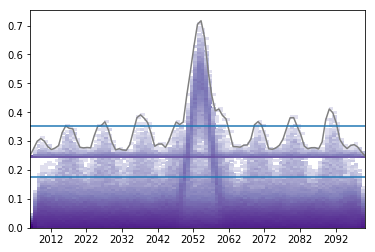

In [15]:
signal = (1.0 / sb[3])
plot_signal_histogram(box, signal, mag_quartiles[4], mag_quartiles[4]/2);

In [16]:
from hyper_canny import cp_edge_thinning, cp_double_threshold

In [17]:
threshold_a = mag_quartiles[4]
threshold_b = mag_quartiles[4]/2

# use directions of pixel based sobel transform and magnitudes from calibrated physical sobel.
dat = pixel_sb.transpose([3,2,1,0]).copy()
mask = cp_edge_thinning(dat)
thinned = mask.transpose([2, 1, 0])
dat = sb.transpose([3,2,1,0]).copy()

In [18]:
thinned *= ~data.mask
thinned[:10] = 0
thinned[-10:] = 0

In [19]:
edges = cp_double_threshold(data=dat, mask=thinned.transpose([2,1,0]), a=1/threshold_a, b=1/threshold_b)
m = edges.transpose([2, 1, 0])

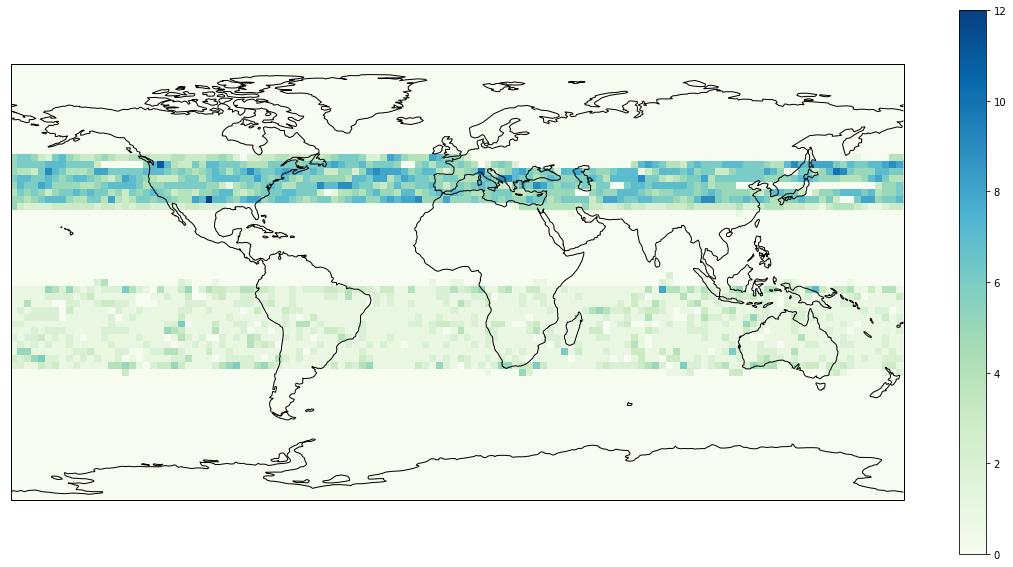

In [20]:
plot_plate_carree(yearly_box, m.sum(axis=0), cmap='GnBu')

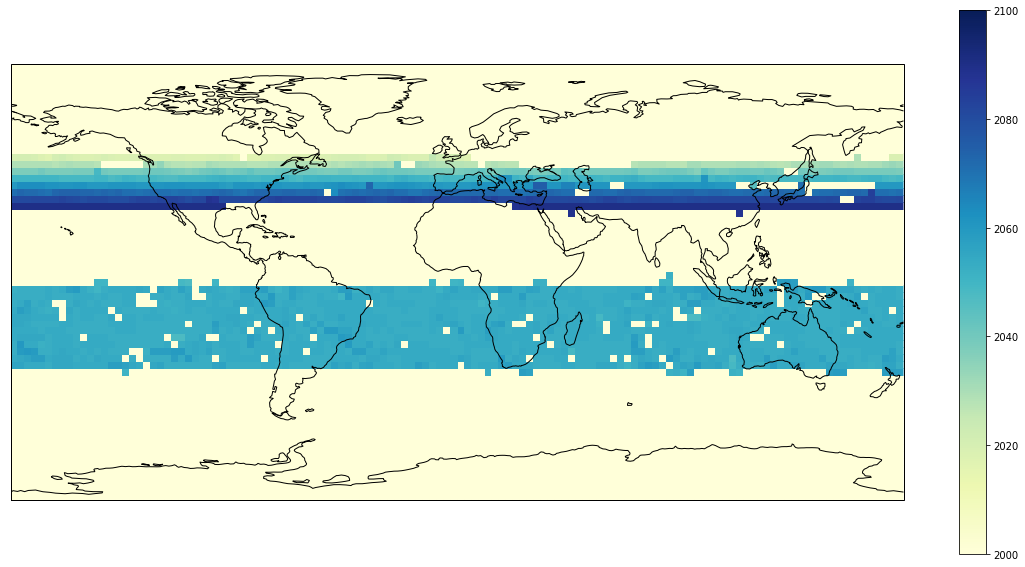

In [21]:
years = np.array([d.year for d in box.dates])
plot_plate_carree(yearly_box, (years[:,None,None]*m).max(axis=0),  cmap='YlGnBu', vmin=2000, vmax=2100)

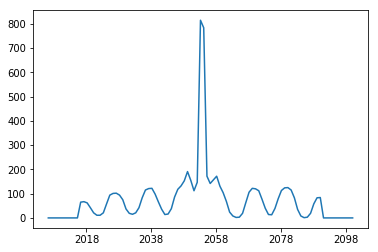

In [22]:
plt.plot(box.dates, m.sum(axis=1).sum(axis=1))
plt.show()

In [23]:
labels, n_features = ndimage.label(m, ndimage.generate_binary_structure(3, 3))
print(n_features)

29


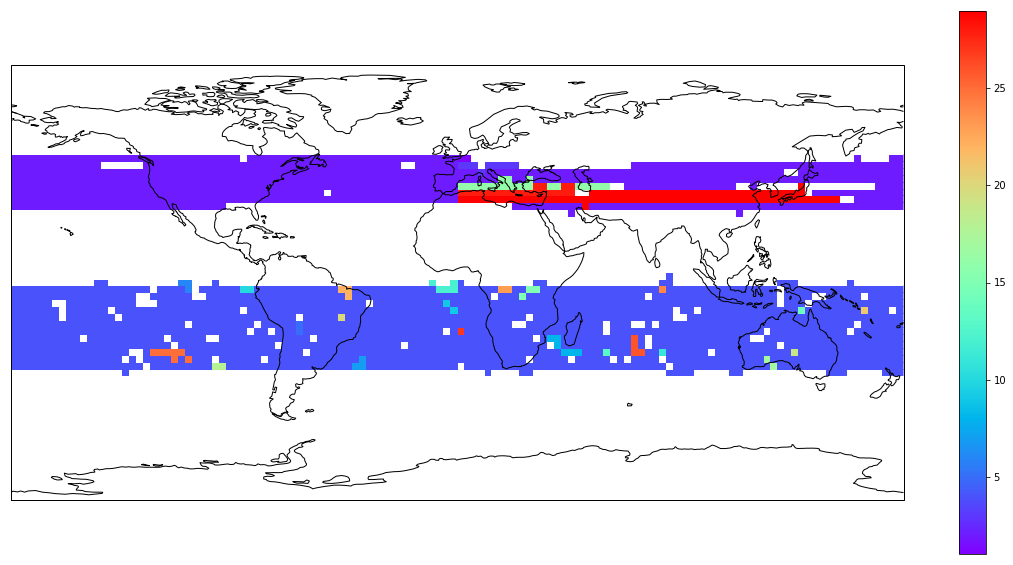

In [24]:
my_cmap = matplotlib.cm.get_cmap('rainbow')
matplotlib.rcParams['figure.figsize'] = (25, 10)
my_cmap.set_under('w')
plot_plate_carree(box, labels.max(axis=0), cmap=my_cmap, vmin=1)

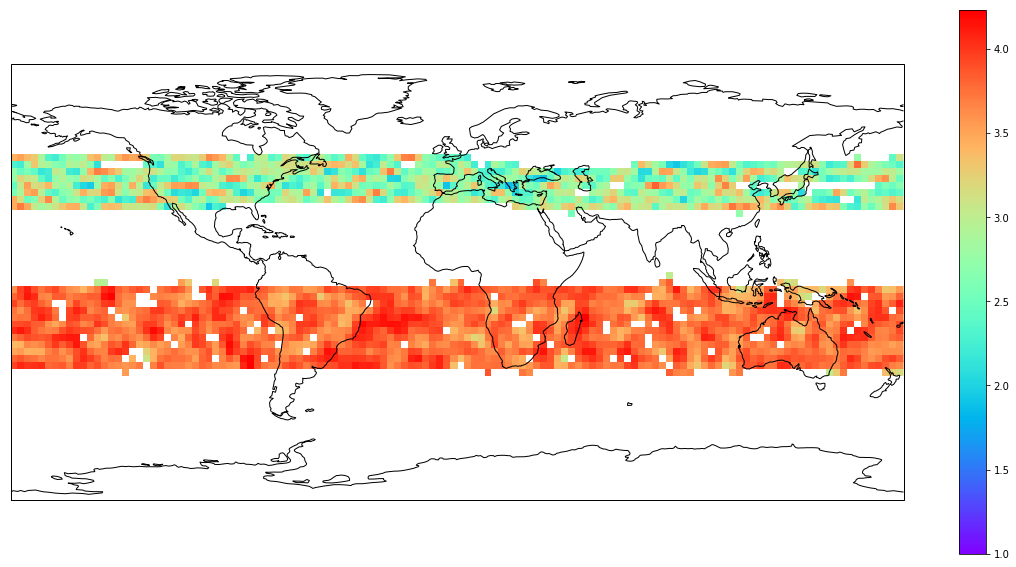

In [25]:
## Global map of peakiness to be added to hypercc as standard output:

tgrad=sb[0]/sb[3] ; #* unit('1/year');
tgrad0=tgrad-np.mean(tgrad, axis=0)  # remove time mean
maxdist=np.max(abs(tgrad0), axis=0)  # maximum distance from mean
stdevdist=np.std(tgrad0, axis=0)     # stdev
peakiness=maxdist/stdevdist          # peakines = maxdist/stdev
maxm=np.max(m, axis=0)

my_cmap = matplotlib.cm.get_cmap('rainbow')
matplotlib.rcParams['figure.figsize'] = (25, 10)
my_cmap.set_under('w')
#plot_plate_carree(box, labels.max(axis=0), cmap=my_cmap, vmin=1)

plot_plate_carree(box, peakiness*maxm, cmap=my_cmap, vmin=1)

In [26]:
## Add this numerical value to standard output (e.g. write into an output file)
# this will allow to sort results regarding peakiness.
np.max(peakiness)

4.2283874